In [18]:
import tensorflow as tf
from keras import layers, Model
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from scipy import stats
from keras.callbacks import Callback
from keras.utils import img_to_array, array_to_img
from keras import Sequential
from keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from keras.models import Model

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.reset_memory_stats(gpu, True)
tf.config.run_functions_eagerly(True)

import warnings
warnings.filterwarnings('ignore')

c = pd.read_csv('../../../Visualizations/color.csv')['color']

In [81]:
month_name='MayJun'
day_type = 'w'
my_data = pd.read_csv(f'ForGAN/{month_name}.csv')
ds = []
if day_type == 'w':
    for c in my_data.columns:
        if 'weekday' in c:
            last = my_data[c].values[-1]
            ds.append(np.concatenate([my_data[c].values, [last, last, last, last]]).reshape([1, 100]))
else:
    for c in my_data.columns:
        if 'weekend' in c:
            last = my_data[c].values[-1]
            ds.append(np.concatenate([my_data[c].values, [last, last, last, last]]).reshape([1, 100]))

max = np.max(ds)
ds = np.divide(ds, max)

### Prepare data to feed into GAN

In [82]:
ds = tf.data.Dataset.from_tensor_slices(ds)
batch_size = 10
ds = ds.cache()
ds = ds.shuffle(1000)
ds = ds.batch(batch_size)
ds = ds.prefetch(64)

## Generator

In [83]:
g_relu = 0.2
def build_generator():
    model = Sequential()

    model.add(Dense(1*100*batch_size, input_dim=batch_size))
    model.add(LeakyReLU(g_relu))
    model.add(Reshape((1,100, batch_size)))

    model.add(Conv2D(batch_size, 5, padding='same'))
    model.add(LeakyReLU(g_relu))

    model.add(Conv2D(batch_size, 5, padding='same'))
    model.add(LeakyReLU(g_relu))

    model.add(Conv2D(batch_size, 5, padding='same'))
    model.add(LeakyReLU(g_relu))

    model.add(Conv2D(batch_size, 5, padding='same'))
    model.add(LeakyReLU(g_relu))

    model.add(Conv2D(1, 5, padding='same', activation='sigmoid'))
    return model
generator = build_generator()
generator.summary()
# series = generator.predict(np.random.randn(4, 6, 1))

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_39 (Dense)            (None, 1000)              11000     
                                                                 
 leaky_re_lu_83 (LeakyReLU)  (None, 1000)              0         
                                                                 
 reshape_12 (Reshape)        (None, 1, 100, 10)        0         
                                                                 
 conv2d_67 (Conv2D)          (None, 1, 100, 10)        2510      
                                                                 
 leaky_re_lu_84 (LeakyReLU)  (None, 1, 100, 10)        0         
                                                                 
 conv2d_68 (Conv2D)          (None, 1, 100, 10)        2510      
                                                                 
 leaky_re_lu_85 (LeakyReLU)  (None, 1, 100, 10)      

## Discriminator

In [85]:
d_relu = 0.2
d_dropout = 0.2
def build_discriminator():
    model = Sequential()

    model.add(Dense(200, input_shape=(1, 100, 1)))
    model.add(LeakyReLU(d_relu))
    model.add(Dropout(d_dropout))

    model.add(Dense(150))
    model.add(LeakyReLU(d_relu))
    model.add(Dropout(d_dropout))

    model.add(Flatten())
    model.add(Dropout(d_dropout))
    model.add(Dense(1, activation='sigmoid'))
    # 1: fake series, 0: real series

    return model
discriminator = build_discriminator()
discriminator.summary()
# Single prediction needs np.expand_dims(series[0], 0)
# discriminator.predict(np.expand_dims(series[0], 0))

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_43 (Dense)            (None, 1, 100, 200)       400       
                                                                 
 leaky_re_lu_90 (LeakyReLU)  (None, 1, 100, 200)       0         
                                                                 
 dropout_42 (Dropout)        (None, 1, 100, 200)       0         
                                                                 
 dense_44 (Dense)            (None, 1, 100, 150)       30150     
                                                                 
 leaky_re_lu_91 (LeakyReLU)  (None, 1, 100, 150)       0         
                                                                 
 dropout_43 (Dropout)        (None, 1, 100, 150)       0         
                                                                 
 flatten_12 (Flatten)        (None, 15000)           

In [86]:
g_a, d_a = 0.0001, 0.00001
g_opt = Adam(learning_rate=g_a)
d_opt = Adam(learning_rate=d_a)  # Does not learn too fast
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()
class LoadGAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        # pass through args and kwargs to base class
        super().__init__(*args, **kwargs)
        # Create attributes for gen and disc
        self.generator = generator
        self.discriminator = discriminator

    def compilee(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        # Compile with base class
        super().compile(*args, **kwargs)

        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss

    def train_step(self, batch):
        real_series = batch
        fake_series = self.generator(tf.random.normal((batch_size, batch_size, 1)), training=False)

        # train the discriminator
        with tf.GradientTape() as d_tape:
            # pass the real and fake images
            yhat_real = self.discriminator(real_series, training=True)
            yhat_fake = self.discriminator(fake_series, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)

            # create labels for real and fake series
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)


            # pass through and add some noise to the outputs
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = 0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)

            # calculate the loss
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)

        # apply backpropagation
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

        # Generator training
        with tf.GradientTape() as g_tape:
            # generate same new images
            gen_series = self.generator(tf.random.normal((batch_size, batch_size, 1)), training=True)

            # create the predicted labels
            predicted_labels = self.discriminator(gen_series, training=False)

            # calculate loss
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)

        # apply backpropagation
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

        return {"d_loss":total_d_loss, "g_loss":total_g_loss}
loadgan = LoadGAN(generator, discriminator)
loadgan.compilee(g_opt, d_opt, g_loss, d_loss)

#### Call Back

In [87]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=batch_size):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vector = tf.random.uniform((self.num_img, self.latent_dim, 1))
        generated_series = self.model.generator(random_latent_vector)
        generated_series *= max
        generated_series.numpy()
        for i in range(self.num_img):
            serie = array_to_img(generated_series[i])


#### Train

In [ ]:
hist = loadgan.fit(ds, epochs=600, callbacks=[ModelMonitor()])

Epoch 1/600
19/19 [==============================] - 2s 97ms/step - d_loss: 0.6787 - g_loss: 0.8504
Epoch 2/600
19/19 [==============================] - 2s 102ms/step - d_loss: 0.6765 - g_loss: 0.8520
Epoch 3/600
19/19 [==============================] - 2s 112ms/step - d_loss: 0.6791 - g_loss: 0.8550
Epoch 4/600
19/19 [==============================] - 2s 98ms/step - d_loss: 0.6784 - g_loss: 0.8592
Epoch 5/600
19/19 [==============================] - 2s 111ms/step - d_loss: 0.6743 - g_loss: 0.8614
Epoch 6/600
19/19 [==============================] - 2s 95ms/step - d_loss: 0.6762 - g_loss: 0.8648
Epoch 7/600
19/19 [==============================] - 2s 93ms/step - d_loss: 0.6765 - g_loss: 0.8663
Epoch 8/600
19/19 [==============================] - 2s 103ms/step - d_loss: 0.6772 - g_loss: 0.8688
Epoch 9/600
19/19 [==============================] - 2s 108ms/step - d_loss: 0.6753 - g_loss: 0.8715
Epoch 10/600
19/19 [==============================] - 2s 95ms/step - d_loss: 0.6756 - g_loss: 0

In [89]:
scenario_size = 30
normal_noise = tf.random.normal((scenario_size, batch_size, 1))
n = [np.random.normal() for _ in range(scenario_size)]
series = np.multiply(generator.predict(normal_noise), max)
resolution = 100
ticks = []
for i in range(resolution):
    if i%4 == 0:
        ticks.append(i)


probabilities = []
ranges = np.linspace(-3.5, 3.5, 8)
intervals = np.linspace(-3, 3, 7)
probs = [stats.norm.cdf(i) for i in n]
prob_ranges = {intervals[i]: [stats.norm.cdf(ranges[i]), stats.norm.cdf(ranges[i+1])] for i in range(len(intervals))}
for i in probs:
    for key in intervals:
        if prob_ranges[key][0]<= i <=prob_ranges[key][1]:
            probabilities.append(prob_ranges[key][1]-prob_ranges[key][0])
            break
scenarios = {'probs': probabilities}
for j in range(resolution):
    scenarios[j] = []
for i in range(scenario_size):
    s = np.multiply(series[i].reshape([resolution]), max)
    for j in range(resolution):
        scenarios[j].append(s[j])
pd.DataFrame(scenarios).to_csv(f'LoadScenarios-{month_name}-{day_type}.csv')

1/1 [==============================] - 0s 35ms/step


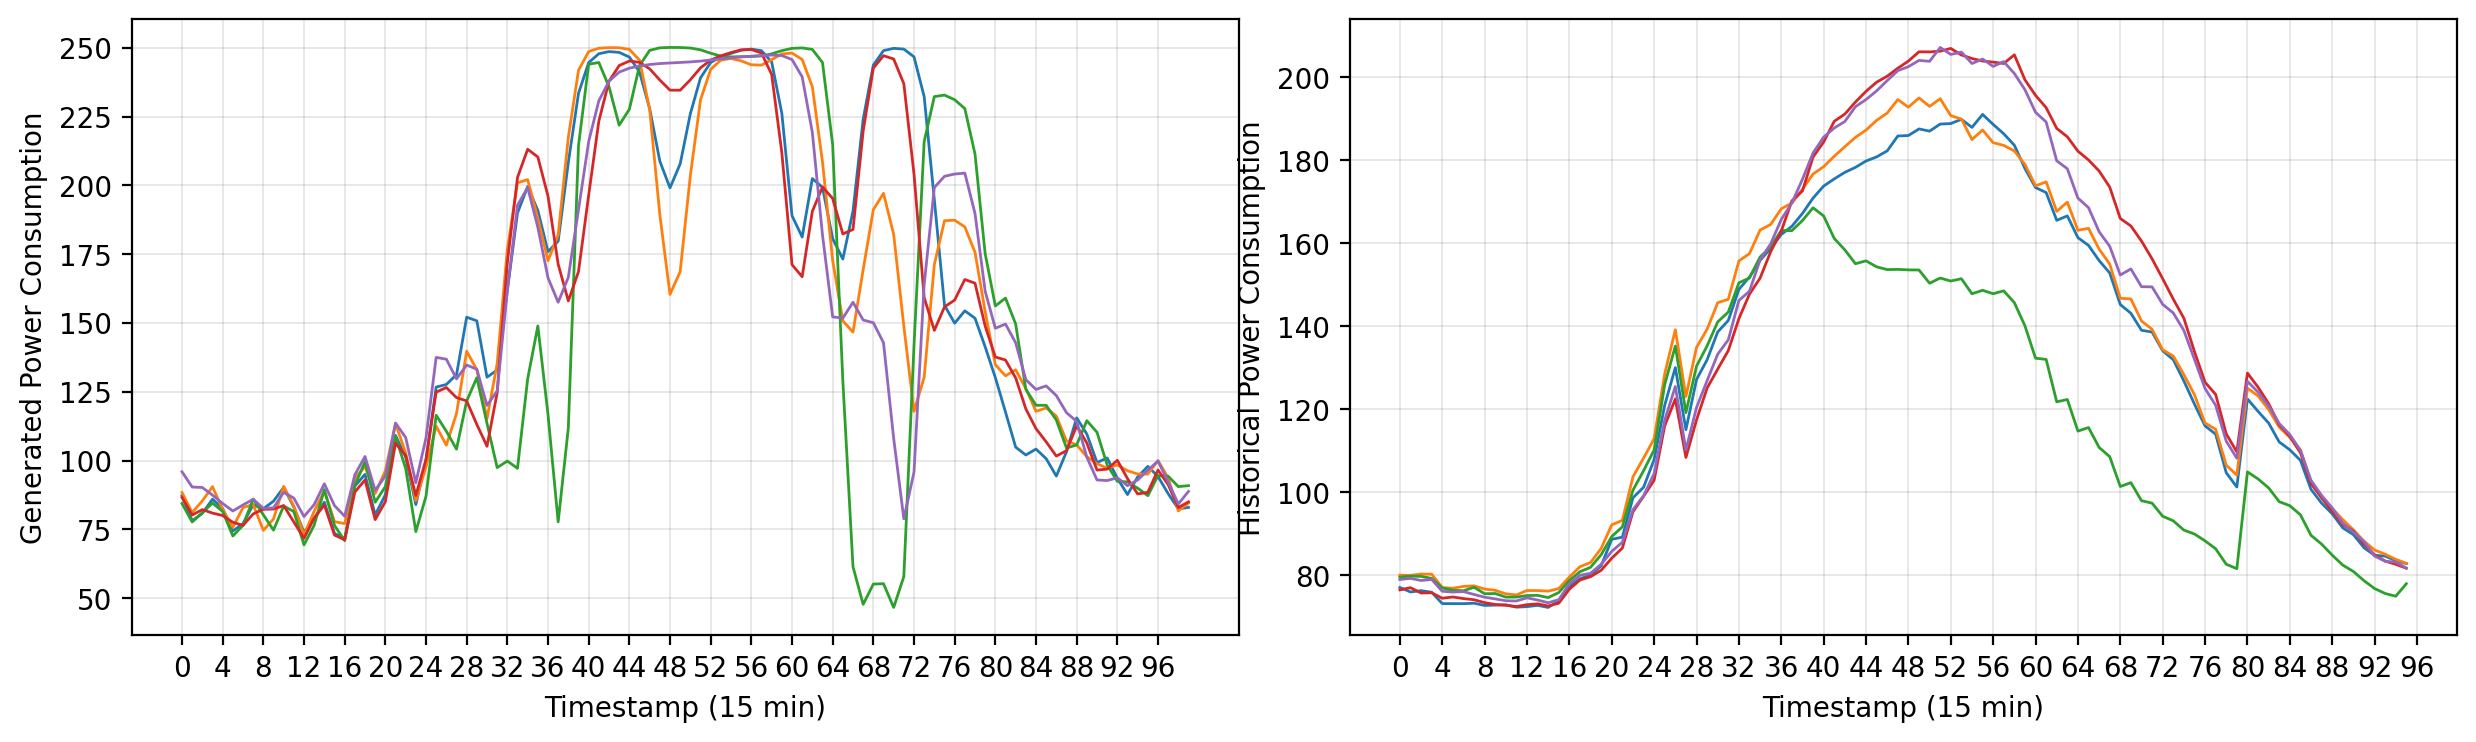

In [90]:
ticks = [i for i in range(resolution) if i%4 == 0]

fig, ax = plt.subplots(1, 2, figsize=(15, 4), dpi=200)
for s in series[:5]:
    ax[0].plot(range(resolution), s.reshape([resolution]), linewidth=1)
ax[0].set_xlabel('Timestamp (15 min)')
ax[0].set_ylabel('Generated Power Consumption')
ax[0].set_xticks(ticks, ticks)
ax[0].grid(color='#666362', linestyle='-', linewidth=0.1)

if day_type == 'w':
    ax[1].plot(my_data[[c for c in my_data.columns if 'weekday' in c][:5]], linewidth=1)
else:
    ax[1].plot(my_data[[c for c in my_data.columns if 'weekend' in c][:5]], linewidth=1)
ax[1].set_xlabel('Timestamp (15 min)')
ax[1].set_ylabel('Historical Power Consumption')
ax[1].set_xticks(ticks, ticks)
ax[1].grid(color='#666362', linestyle='-', linewidth=0.1)
plt.subplots_adjust(wspace=0.1)

plt.savefig(f'IMG/{month_name}-{day_type}.jpg', bbox_inches='tight')

### Save models

In [71]:
generator.save(f'HarrisCounty/GAN Models/generator-{month_name}-{day_type}.h5')
discriminator.save(f'HarrisCounty/GAN Models/discriminator-{month_name}-{day_type}.h5')


FileNotFoundError: [Errno 2] No such file or directory: 'HarrisCounty/IMG/Jan-w-loss.jpg'

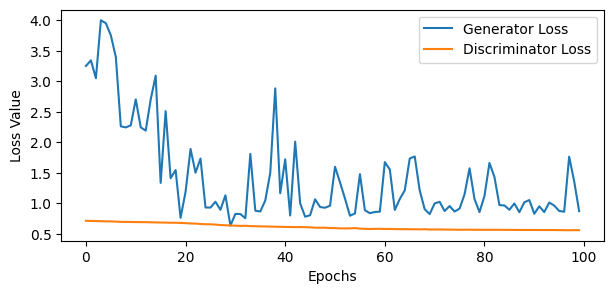

In [48]:
plt.figure(figsize=(7, 3), dpi=100)
plt.plot(hist.history['d_loss'], label='Generator Loss')
plt.plot(hist.history['g_loss'], label='Discriminator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.legend()
plt.savefig(f'HarrisCounty/IMG/{month_name}-{day_type}-loss.jpg', bbox_inches='tight')